<a href="https://colab.research.google.com/github/Nastarii/Elderly-living-monitoring/blob/main/PCB_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Packages

In [2]:
!pip install imageio

!wget --no-check-certificate \
    "https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip" \
    -O "/tmp/DeepPCB.zip"

--2021-09-25 01:16:23--  https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master [following]
--2021-09-25 01:16:24--  https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/DeepPCB.zip’

/tmp/DeepPCB.zip        [          <=>       ]  86.79M  18.4MB/s    in 4.8s    

2021-09-25 01:16:29 (18.2 MB/s) - ‘/tmp/DeepPCB.zip’ saved [91004517]



# Libraries

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import zipfile
import imageio
import imgaug
import torch
import PIL
import os

# Unzip Dataset

In [4]:
zip_format = zipfile.ZipFile('/tmp/DeepPCB.zip','r')
zip_format.extractall('/tmp')
zip_format.close()

# Preparing Data

In [5]:
directory = '/tmp/DeepPCB-master/PCBData/'

train_val_paths = pd.read_csv(directory + 'trainval.txt', delimiter = " ",header= None)
test_paths = pd.read_csv(directory + 'test.txt', delimiter = " ", header= None)

In [6]:
df = pd.concat([train_val_paths, test_paths],axis=0).sample(frac=1,random_state=42).drop(0,axis=1).rename(columns={1:'txt_files'})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 116 to 126
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   txt_files  1500 non-null   object
dtypes: object(1)
memory usage: 23.4+ KB


In [8]:
train_files = df['txt_files'][:1300].values
test_files = df['txt_files'][:-200].values

In [9]:
train_dir = '/tmp/Model/train'

os.makedirs(train_dir)

In [10]:
class_names = ['open','short','mousebite','spur','copper','pin-hole']
dirs = []

for name in class_names:
    dirs.append(train_dir + '/' + name)

In [11]:
for dir in dirs:
    os.makedirs(dir)

In [12]:
count = 0
class_imgs = []

for txt in train_files:

    read_txt = pd.read_csv(directory + txt, delimiter= " ", header=None)
    img_path = txt.replace("_not","").replace(".txt","_test.jpg")

    for i in range (len(read_txt)):

        label = read_txt.iloc[i][4]
        crop_area = read_txt.iloc[i][:4]

        image = PIL.Image.open(directory + img_path)
        image = image.crop(crop_area)
        image.save(dirs[label - 1] + '/' + str(count) + '.jpg')
        class_imgs.append(np.asarray(image,dtype='float32'))
        count = count + 1

# Model

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8737 files belonging to 6 classes.
Using 6990 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8737 files belonging to 6 classes.
Using 1747 files for validation.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(6)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [39]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
219/219 [==============================] - 12s 50ms/step - loss: 0.4074 - accuracy: 0.8631 - val_loss: 0.2106 - val_accuracy: 0.9313
Epoch 2/8
219/219 [==============================] - 11s 49ms/step - loss: 0.1948 - accuracy: 0.9418 - val_loss: 0.1225 - val_accuracy: 0.9674
Epoch 3/8
219/219 [==============================] - 11s 49ms/step - loss: 0.1470 - accuracy: 0.9589 - val_loss: 0.1198 - val_accuracy: 0.9697
Epoch 4/8
219/219 [==============================] - 11s 49ms/step - loss: 0.1189 - accuracy: 0.9649 - val_loss: 0.0840 - val_accuracy: 0.9754
Epoch 5/8
219/219 [==============================] - 11s 48ms/step - loss: 0.1074 - accuracy: 0.9694 - val_loss: 0.0896 - val_accuracy: 0.9742
Epoch 6/8
219/219 [==============================] - 11s 48ms/step - loss: 0.0908 - accuracy: 0.9710 - val_loss: 0.0662 - val_accuracy: 0.9800
Epoch 7/8
219/219 [==============================] - 11s 48ms/step - loss: 0.0766 - accuracy: 0.9783 - val_loss: 0.0749 - val_accuracy: 0.9794

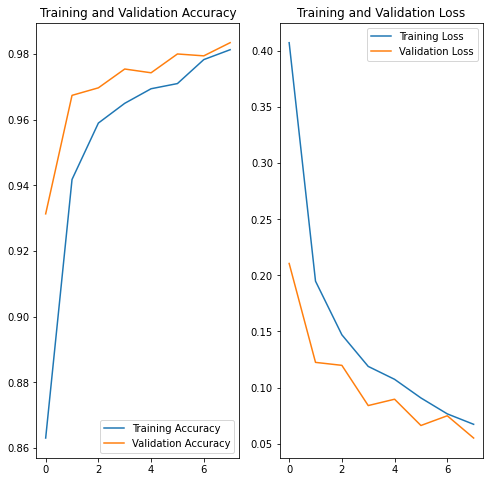

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()